# Accelerate the Metropolis Process by Numba

### 25.811s for 1E6 MC Steps on ISing Model with 10x10 Grids 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [2]:
import copy
import time

In [3]:
import numba as nb

In [4]:
### fix the random seed
seed = 0
np.random.seed(seed)

-----------

In [5]:
global grids, dims, beta, j, h, delta

In [6]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grids, dims, beta, j, h
    dims = (nb.int8(dims_init[0]), nb.int8(dims_init[1]))
    beta, j, h = nb.int8(beta_init), nb.int8(j_init), nb.int8(h_init)
    grids = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [7]:
### initialize the parameters
dims_init = (10, 10)
beta_init, j_init, h_init = 1, 1, 0

In [8]:
parameters_init(dims_init, beta_init, j_init, h_init)

--------------

In [9]:
types_neibor_get = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 6)(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibor_get)
def neibor_get(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, (width_index - 1) % width)
    r_neibor = (height_index, (width_index + 1) % width)
    u_neibor = ((height_index - 1) % height, width_index)
    d_neibor = ((height_index + 1) % height, width_index)          
    ur_neibor = ((height_index - 1) % height, (width_index + 1) % width)
    dl_neibor = ((height_index + 1) % height, (width_index - 1) % width)
    return (l_neibor, r_neibor, u_neibor, d_neibor, ur_neibor, dl_neibor)

In [10]:
types_energy_compute_one_grid = nb.int32(nb.int8[:, :], nb.types.UniTuple(nb.int8, 2), nb.int8)
@nb.njit(types_energy_compute_one_grid)
def energy_compute_one_grid(grids, id_grid, id_spin):
    energy_one_site = 0
    id_neibors = neibor_get(id_grid)
    for neibor in id_neibors:
        energy_one_site += -j * grids[neibor[0]][neibor[1]] * id_spin
    energy_one_site += -h * id_spin
    return energy_one_site

In [11]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibor_get((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [12]:
@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grids):
    m = 0
    for ii in range(dims[0]*dims[1]):
        row_grids, col_grids = ii // dims[1], ii % dims[1] 
        m += grids[row_grids][col_grids]
    m_avg = m / (dims[0] * dims[1])
    return m_avg

In [13]:
@nb.njit(nb.int8[:, :](nb.int8[:, :]))
def one_site_mcmc(grids):
    id_random = np.random.randint(dims[0]*dims[1])
    id_height, id_width = nb.int8(id_random // dims[1]), nb.int8(id_random % dims[1])
    spin_old = grids[id_height][id_width]
    spin_new = nb.int8(-1 * spin_old)
    energy_old = energy_compute_one_grid(grids, (id_height, id_width), spin_old)
    energy_new = energy_compute_one_grid(grids, (id_height, id_width), spin_new)
    energy_delta = energy_new - energy_old
    if energy_delta <= 0:
        grids[id_height][id_width] = spin_new
    else:
        prob_accept = np.exp(-beta * energy_delta)
        if np.random.random() < prob_accept:
            grids[id_height][id_width] = spin_new
    return grids

In [14]:
@nb.njit(nb.int8[:, :](nb.int8[:, :]))
def one_step_mcmc(grids):
    for _ in range(dims[0]*dims[1]):
        grids = one_site_mcmc(grids)
    return grids

In [15]:
@nb.njit(nb.float32[:](nb.int8[:, :], nb.int32))
def mcmc(grids, steps):
    energy_history = np.zeros(steps, dtype=np.float32)
    for i in range(steps):
        grids = one_step_mcmc(grids)
        energy_per_spin = energy_compute_grids(grids)
        energy_history[i] = energy_per_spin
    return energy_history

In [16]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grids*np.pi/2)
    v = np.sin(grids*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

In [17]:
def spin_viz_dynamic(self, spins_list, file_name, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(spins_list[0]*np.pi/2)
    v = np.sin(spins_list[0]*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title(f'T={1/beta:.3f}, dims={dims}', fontsize=20)            
    def update_quiver(num, q):
        u = np.cos(spins_list[num+1]*np.pi/2)
        v = np.sin(spins_list[num+1]*np.pi/2)
        q.set_UVC(u, v)
        return q
    frames = len(spins_list) - 1
    anim = animation.FuncAnimation(fig, update_quiver, frames=frames, 
                                   fargs=(q, ), interval=50, repeat=False)
    writergif = animation.PillowWriter(fps=100) 
    anim.save(f'./{file_name}.gif', writer=writergif)

--------

In [18]:
grids

array([[-1,  1,  1, -1,  1,  1,  1,  1,  1,  1],
       [ 1, -1, -1,  1, -1, -1, -1, -1, -1,  1],
       [-1,  1,  1, -1, -1,  1,  1,  1,  1, -1],
       [ 1, -1,  1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1, -1,  1],
       [-1,  1,  1,  1,  1, -1,  1, -1, -1,  1],
       [ 1, -1,  1, -1,  1, -1, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1,  1,  1, -1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1,  1, -1],
       [ 1,  1, -1, -1,  1, -1, -1,  1,  1, -1]], dtype=int8)

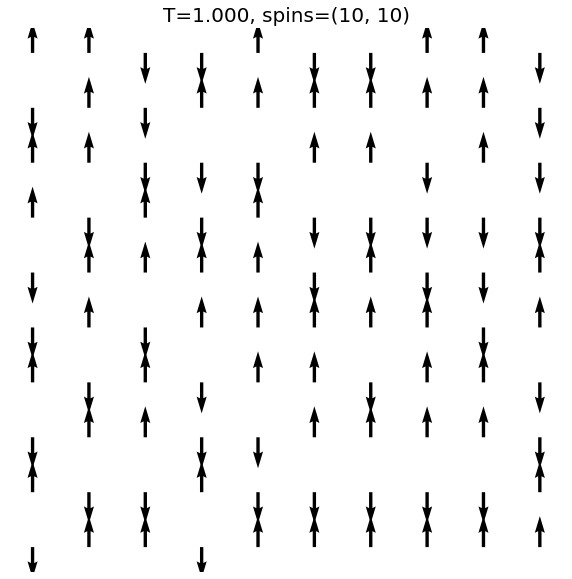

In [19]:
spin_viz()

In [20]:
time_start = time.time()
energy_history = mcmc(grids, 1000000)
time_end = time.time()
print(f"Time used for 1E6 steps is: {time_end-time_start}.")

Time used for 1E6 steps is: 25.811068534851074.


In [ ]:
plt.plot(energy_history[:4000], '-r')
plt.xlabel("MC steps", fontsize=15)
plt.ylabel("Energy_Per_Spin")

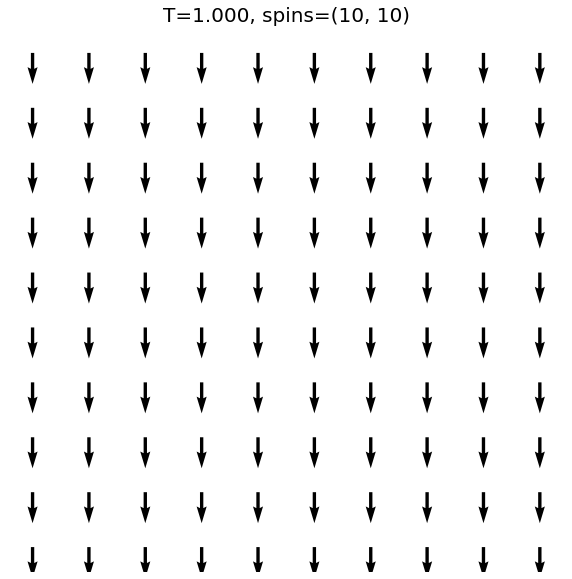

In [22]:
spin_viz()

----